# Ungraded Lab: Training a Sarcasm Detection Model using a Convolution Layer

You will be doing the same steps here as the previous lab but will be using a convolution layer instead. As usual, try tweaking the parameters and observe how it affects the results.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Load the Dataset

In [1]:
import os
try:
    import wget
except ModuleNotFoundError:
    print("Installing wget module...")
    !pip install wget
    import wget

def download_dataset(url, folder, filename):
    # Check if the folder exists, otherwise, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = os.path.join(folder, filename)

    # Check if the file has already been downloaded
    if not os.path.exists(file_path):
        print(f"Downloading file from {url}...")
        wget.download(url, out=folder)
        print("\nDownload completed.")
    else:
        print("The file has already been downloaded.")

# Specify the URL of the file, the destination folder, and the filename
url = "https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json"
folder = "Datasets"
filename = "sarcasm.json"

# Call the function to download the file.
download_dataset(url, folder, filename)

Installing wget module...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=d16114163fb4204341977f70a282a0cd565b9c0666cb5efcb10aaec6daff441d
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Download completed.


In [2]:
import json

def load_json_file(file_path):
    # Load the JSON file
    with open(file_path, 'r') as f:
        json_data = json.load(f)
    return json_data

# Example usage
datastore = load_json_file("./Datasets/sarcasm.json")

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## Parameters

In [3]:
# Number of examples to use for training
TRAINING_SIZE = 20000

# Vocabulary size of the tokenizer
VOCAB_SIZE = 10000

# Maximum length of the padded sequences
MAX_LENGTH = 32

# Type of padding
PADDING_TYPE = 'pre'

# Specifies how to truncate the sequences
TRUNC_TYPE = 'post'

## Split the Dataset

In [4]:
# Split the sentences
train_sentences = sentences[0:TRAINING_SIZE]
test_sentences = sentences[TRAINING_SIZE:]

# Split the labels
train_labels = labels[0:TRAINING_SIZE]
test_labels = labels[TRAINING_SIZE:]

## Data preprocessing

In [5]:
import tensorflow as tf

def prepare_datasets(train_sentences, train_labels, test_sentences, test_labels, vocab_size):
    """
    Prepares TensorFlow datasets and a TextVectorization layer for text processing.

    Args:
        train_sentences (list): List of training sentences.
        train_labels (list): Corresponding labels for the training sentences.
        test_sentences (list): List of testing sentences.
        test_labels (list): Corresponding labels for the testing sentences.
        vocab_size (int): Maximum size of the vocabulary for the vectorization layer.

    Returns:
        tuple: A tuple containing the TextVectorization layer, training dataset, and testing dataset.
    """
    # Instantiate the vectorization layer
    vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)

    # Generate the vocabulary based on the training inputs
    vectorize_layer.adapt(train_sentences)

    # Create TensorFlow datasets from sentences and labels
    train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

    return vectorize_layer, train_dataset, test_dataset

vectorize_layer, train_dataset, test_dataset = prepare_datasets(train_sentences, train_labels, test_sentences, test_labels, VOCAB_SIZE)

In [6]:
def preprocessing_fn(dataset):
    """
    Generates padded sequences from a tf.data.Dataset

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset containing text features and labels.

    Returns:
        tf.data.Dataset: A TensorFlow dataset containing padded sequences paired with their labels.
    """

    # Apply the vectorization layer to the reviews
    dataset_sequences = dataset.map(lambda review, label: (vectorize_layer(review), label))

    # Put all elements in a single ragged batch
    dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())

    # Output a tensor from the single batch. Extract the sequences and labels.
    sequences, labels = dataset_sequences.get_single_element()

    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), maxlen=MAX_LENGTH, truncating=TRUNC_TYPE, padding=PADDING_TYPE)

    # Convert back to a tf.data.Dataset
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels = tf.data.Dataset.from_tensor_slices(labels)

    # Combine the padded sequences and labels
    dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

    return dataset_vectorized

In [7]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

In [8]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print("="*80)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  319,    1,
        943, 4079, 2366,   47,  366,   94, 2026,    6, 2653, 9470],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    4, 7185, 3128, 3305,
         28,    2,  152,    1,  358, 2902,    6,  236,    9,  844],
      dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


In [9]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

def optimize_dataset(dataset_vectorized, shuffle=False):
    '''
    Optimizes the dataset for training.

    Args:
        dataset_vectorized (tf.data.Dataset): Dataset containing the vectorized data.
        shuffle (bool): Indicates whether to shuffle the dataset or not. Default is False.

    Returns:
        tf.data.Dataset: Optimized dataset with caching, prefetching, and batching applied.
    '''
    dataset_final = dataset_vectorized.cache()
    dataset_final = dataset_final.shuffle(SHUFFLE_BUFFER_SIZE) if shuffle else dataset_final
    dataset_final = dataset_final.prefetch(buffer_size=PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset_final

train_dataset_final = optimize_dataset(train_dataset_vectorized, shuffle=True)
test_dataset_final = optimize_dataset(test_dataset_vectorized)

## Plot Utility

In [10]:
import matplotlib.pyplot as plt

def plot_accuracy_loss_history(history):
    """
    Plots training and validation metrics (accuracy and loss) over epochs in subplots.

    Args:
        history (History): History object returned by the fit method of a Keras model.

    Returns:
        None: Displays a figure with two subplots for accuracy and loss.
    """
    metrics = ['accuracy', 'loss']

    # Create a figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    for i, metric in enumerate(metrics):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history[f'val_{metric}'])
        axs[i].set_title(f'TRAINING AND VALIDATION {metric.upper()}')
        axs[i].set_xlabel("Epochs")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend([metric, f'val_{metric}'])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

## Build and Compile the Model

In [11]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, Conv1D, GlobalAveragePooling1D, Dense

class ConvolutionalModel:
    def __init__(self, max_length, vocab_size, embedding_dim, filters, kernel_size, dense_dim):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.filters = filters
        self.kernel_size = kernel_size
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(self.max_length,)),
            Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim),
            Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu'),
            GlobalAveragePooling1D(),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [12]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Create an instance of the SentimentModel class
convolutional_model = ConvolutionalModel(MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM, FILTERS, KERNEL_SIZE, DENSE_DIM)

# Print the summary
convolutional_model.summary()

# Compile the model
convolutional_model.compile_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 16)              │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 28, 128)             │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [13]:
NUM_EPOCHS = 10

convolutional_history = convolutional_model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.6778 - loss: 0.5617 - val_accuracy: 0.8459 - val_loss: 0.3536
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8879 - loss: 0.2725 - val_accuracy: 0.8427 - val_loss: 0.3782
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9253 - loss: 0.2001 - val_accuracy: 0.8395 - val_loss: 0.4261
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9425 - loss: 0.1552 - val_accuracy: 0.8343 - val_loss: 0.4937
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9599 - loss: 0.1206 - val_accuracy: 0.8353 - val_loss: 0.5715
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9720 - loss: 0.0907 - val_accuracy: 0.8325 - val_loss: 0.6495
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9802 - loss: 0.0673 - val_accuracy: 0.8322 - val_loss: 0.7457
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9864 - loss: 0.0492 - val_accuracy: 

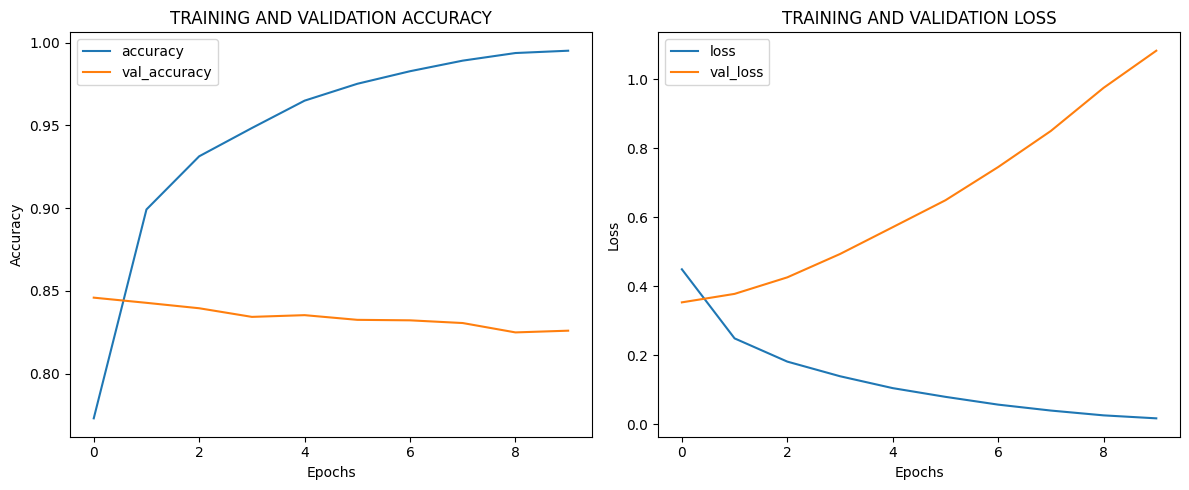

In [14]:
# Plot the accuracy and loss history
plot_accuracy_loss_history(convolutional_history)